In [132]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from scipy.optimize import curve_fit

In [133]:
datadir='../XYscan data/610 150 GHz/'
Yscanfile, Xscanfile = glob(datadir + '*.txt')

In [134]:
time,posno,xpos,ypos, Vx = np.loadtxt(Yscanfile, skiprows=9, delimiter=',', unpack=True, usecols=[0,1,2,3,5])

In [135]:
t = time[10:-10].reshape([10,15,15],order='F')
X = xpos[10:-10].reshape([10,15,15],order='F')
Y = ypos[10:-10].reshape([10,15,15],order='F')
V = Vx[10:-10].reshape([10,15,15], order='F')
Vavg = np.average(V, axis=0)
tavg = np.average(t, axis=0) #newly defined
Verr = np.std(V, axis=0)
Xarr = X[0,:,:]
Yarr = Y[0,:,:]
for k in range(1,X.shape[2],2):
    Yarr[:,k] = Yarr[::-1,k]
    Vavg[:,k] = Vavg[::-1,k]
    Verr[:,k] = Verr[::-1,k]
    tavg[:,k] = tavg[::-1,k] #newly implemented
print(Yarr[0,:])

[-3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5 -3.5]


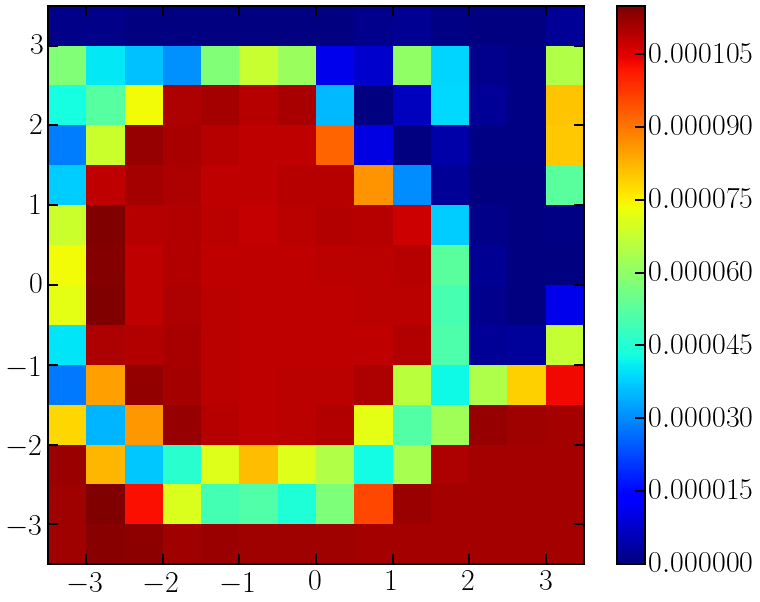

In [136]:
plt.figure(figsize=(12,10))
plt.pcolor(Xarr,Yarr,Vavg,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

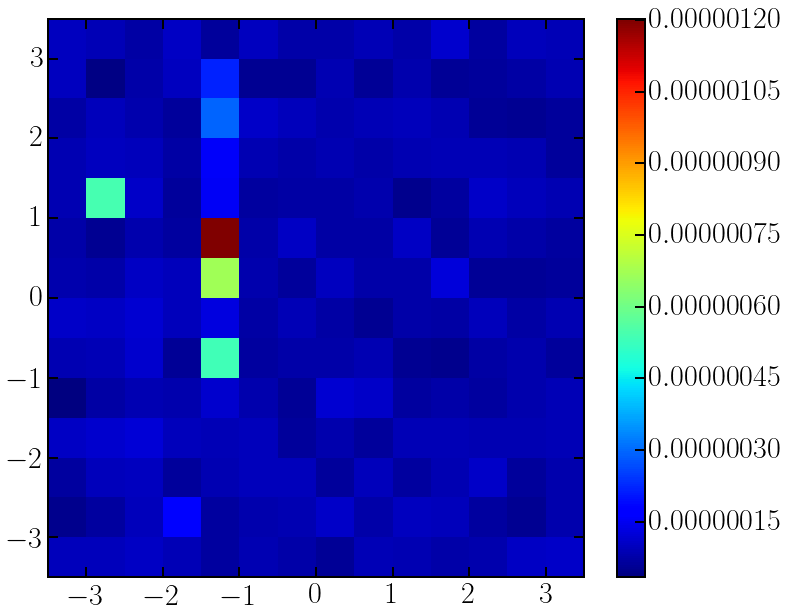

In [137]:
plt.figure(figsize=(12,10))
plt.pcolor(Xarr,Yarr,Verr,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();

In [138]:
# ref_t = t[0, :]
# ref_V = V[0,:]
# print(ref_t)

In [139]:
#fig, ax = plt.subplots(figsize=(15,10))
#ax.plot(ref_t, ref_V, 'rx-', markersize=20);

In [140]:
# def polyfit(x, *coeffs):
#     n = len(coeffs)
#     y = np.sum([coeffs[i]*x**i for i in range(n)])

Now we have to take into account the dependence of transmission over time. In order to do this we use the reference part (i.e. the bottom red row of the figure where the filter did not cover) and make a 5d polynomial fit fitted(time) of the time dependence vs the amplitude. The other datas taken at time t will be later normalized by dividing the amplitude by fitted(t).

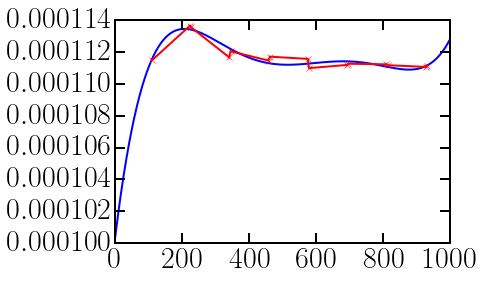

In [141]:
#take the reference part from the average calculated before
tavg_ref=tavg[0,:]
Vavg_ref=Vavg[0,:]
#print(tavg_ref)
#print(Vavg_ref)

#fit with 5d polynomial
fit_coeff=np.polyfit(tavg_ref,Vavg_ref,5)
#print(fit_coeff) 
fitted=np.poly1d(fit_coeff) # fitted as fit_coeff[0]*x**5+fit_coeff[1]*x**4+...+fit_coeff[5]

#plot
t1 = np.arange(0., 1000, 1)

plt.plot(fitted(t1), 'b-', tavg_ref, Vavg_ref, 'rx-')

As mentioned before we normalize all the data by the fitted time-evolution polynomial, and plot the normalized amplitude. As we will check later this will make the reference part (i.e. the first row) almost equal to one.

In [142]:
Vavg_normalized=Vavg/fitted(tavg)
print(Vavg_normalized[0,:]) #check the first row

[ 0.99934493  1.0020544   1.0012283   0.99489316  0.99866442  1.00146832
  1.0037904   1.00270644  0.99744307  0.99797861  0.99866707  1.00129046
  1.00095431  0.99964423  0.99987263]


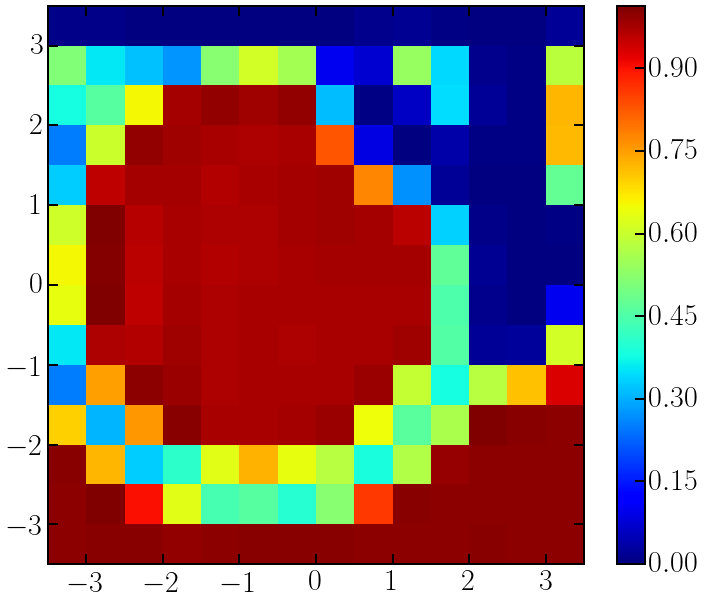

In [143]:
plt.figure(figsize=(12,10))
plt.pcolor(Xarr,Yarr,Vavg_normalized,snap=True,cmap='jet');
plt.axis('tight')
plt.colorbar();